In [32]:
# data
import pandas as pd

# plotting
import plotly.graph_objs as go
import matplotlib.pyplot as plt
%matplotlib inline

# forecasting
import fbprophet as prophet

# from imports
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot  # for offline use
from pandas.io import gbq

from query import Query  # custom -> export PYTHONPATH=/path/to/query.py
from tools import bounded_graph  # externalized 

# run plotly offline and initialize notebook plotting
init_notebook_mode(connected=True)

# Historical EPA data from `bigquery-public-data`

## Temperature data for `state_code-county_code-site_num = 29-510-0094`
$29-510-0094 \equiv$ Missouri-St. Louis-Forest Park (__[see here](https://www.federalregister.gov/documents/2018/01/05/2018-00037/air-plan-approval-and-air-quality-designation-mo-redesignation-of-the-missouri-portion-of-the-st)__, and a __[general list of state_code-county_code pairs](https://www3.epa.gov/ttnairs1/airsaqsORIG/manuals/city_names.pdf)__)

In [33]:
# create query to gather historical data
state_code = "29"
county_code = "510"
site_num = "0094"

q = Query(SELECT="sample_measurement, "
                 "TIMESTAMP(CONCAT(CAST(date_gmt AS STRING), ' ', time_gmt, ':00'), 'UTC') AS timestamp",
          FROM="`bigquery-public-data.epa_historical_air_quality.temperature_hourly_summary`",
          WHERE=f"state_code = {state_code!r} AND county_code = {county_code!r} AND site_num = {site_num!r}",
          ORDERBY="timestamp ASC")

# NOTE: the read_ts method is too specific for this case, so we do it manually
df = gbq.read_gbq(str(q), dialect='standard')

INFO:pandas_gbq.gbq:Query running...
INFO:pandas_gbq.gbq:Total time taken 7.85 s.
Finished at 2018-10-18 14:00:10.


In [34]:
# transform timestamps to datetime and set index to datetime
df.timestamp = pd.to_datetime(df.timestamp)
df.index = df.timestamp

# convert values from fahrenheit to celsius
df.sample_measurement = (df.sample_measurement - 32) * 5 / 9 

# resample data
resample_rule = "6H"  # average over 6h
df_resampled = df.resample(resample_rule).mean()

## Forecasting

In [35]:
# set the size of training data (last 10% for training)
lim = int(len(df_resampled) * 0.9)

# Prophet requires columns ds (Date) and y (value) 
train_T = df_resampled[:lim]  # set training set
test_T = df_resampled[lim:]  # set testing set
train_T = train_T.rename(columns={'sample_measurement': 'y'})  # rename column to 'y'
train_T['ds'] = train_T.index  # rename column to 'ds'

# Make the prophet model and fit on the data using default values, but enforcing yearly seasonality
T_prophet = prophet.Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
T_prophet.fit(train_T)


# Make a future dataframe in steps of 12H
T_forecast = T_prophet.make_future_dataframe(periods=600, freq='12H')

# Make predictions
T_forecast = T_prophet.predict(T_forecast)  # also contains historical data

## Plotting

In [36]:
train_trace = go.Scatter(x=train_T.index, 
                         y=train_T.y,  # get data attribute of DataFrame
                         mode="markers",  # setting markers instead of lines
                         marker={'size': 4,
                                 'color': 'rgb(0, 0, 0)'},  # black
                         name="[train]")  # latex doesn't work right now for plotly for some reason... 
test_trace = go.Scatter(x=test_T.index,
                        y=test_T.sample_measurement,
                        mode="markers",
                        marker={'size': 4,
                                'color': '#d62768'},
                        name="[test]")

# use externalised wrapper 
model = bounded_graph(T_forecast[:lim], forecast_args = {"name": "Model",
                                                         "marker": {"color": "#1F77B4"},
                                                         "line": {"width": 3}})

forecast = bounded_graph(T_forecast[lim:], forecast_args = {"name": "Forecast",
                                                            "marker": {"color": "#1F77B4"},
                                                            "line": {"width": 3,
                                                                     "dash": "dash"}})

# order of traces is very important because lower_trace has option "fill to next y": it must follow upper trace
data = [train_trace, test_trace, *model, *forecast]

# setting layout options
layout = go.Layout(showlegend=True, title=f"Historical timeseries + forecast | EPA station {state_code}-{county_code}-{site_num}", 
                   width=900, height=700)

# creating figure object
fig = go.Figure(data=data, layout=layout)

# cosmetics
fig.layout.yaxis.update({'title': f"{resample_rule}-average Temperature [°C]"})
fig.layout.xaxis.update({'title': f"Time [steps of {resample_rule}]"})

# actual plotting
iplot(fig, image='svg', filename='epa_temp')

### quick overview of trend 
Splitup is where forecast starts

Text(0.5, 1.0, 'trend for 6h average model')

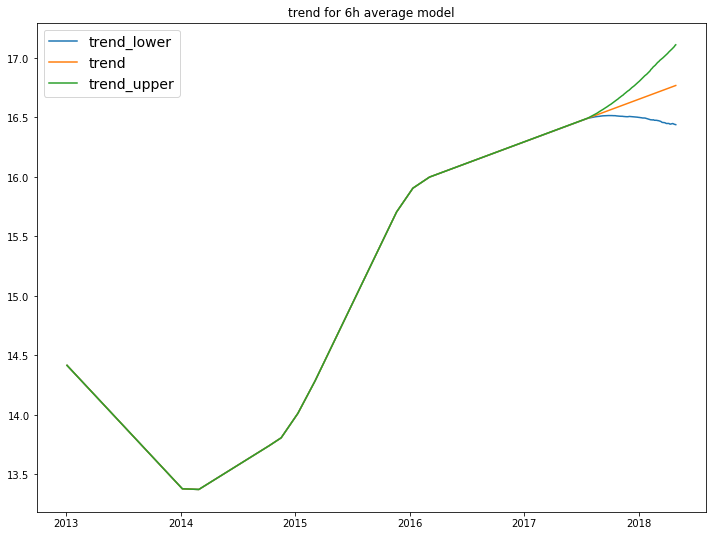

In [37]:
plt.figure(figsize=(12, 9))
for t in ['trend_lower', 'trend', 'trend_upper']:
    plt.plot(T_forecast.ds, getattr(T_forecast, t), label=t)
plt.legend(fontsize=14)
plt.title('trend for 6h average model')

## daily averages + forecast

In [38]:
# resample data
resample_rule = "1D"  # average over 1 day
df_daily = df.resample(resample_rule).mean()

# forecasting ----------------------------------------------------------------------
# set the size of training data (last 10% for training)
lim = int(len(df_daily) * 0.9)

# Prophet requires columns ds (Date) and y (value) 
train_T = df_daily[:lim]  # set training set
test_T = df_daily[lim:]  # set testing set
train_T = train_T.rename(columns={'sample_measurement': 'y'})  # rename column to 'y'
train_T['ds'] = train_T.index  # rename column to 'ds'

# Make the prophet model and fit on the data using default values, but enforcing yearly seasonality
T_prophet = prophet.Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
T_prophet.fit(train_T)


# Make a future dataframe in steps of 12H
T_forecast = T_prophet.make_future_dataframe(periods=300, freq='1D')

# Make predictions
T_forecast = T_prophet.predict(T_forecast)  # also contains historical data

# plotting --------------------------------------------------------------------------------
train_trace = go.Scatter(x=train_T.index, 
                         y=train_T.y,  # get data attribute of DataFrame
                         mode="markers",  # setting markers instead of lines
                         marker={'size': 4,
                                 'color': 'rgb(0, 0, 0)'},  # black
                         name="[train]")  # latex doesn't work right now for plotly for some reason... 
test_trace = go.Scatter(x=test_T.index,
                        y=test_T.sample_measurement,
                        mode="markers",
                        marker={'size': 4,
                                'color': '#d62768'},
                        name="[test]")

# use externalised wrapper 
model = bounded_graph(T_forecast[:lim], forecast_args = {"name": "Model",
                                                         "marker": {"color": "#1F77B4"},
                                                         "line": {"width": 3}})

forecast = bounded_graph(T_forecast[lim-1:], forecast_args = {"name": "Forecast",
                                                              "marker": {"color": "#1F77B4"},
                                                              "line": {"width": 3,
                                                                       "dash": "dash"}})

# order of traces is very important because lower_trace has option "fill to next y": it must follow upper trace
data = [train_trace, test_trace, *model, *forecast]

# setting layout options
layout = go.Layout(showlegend=True, title=f"Historical timeseries + forecast | EPA station {state_code}-{county_code}-{site_num}", 
                   width=900, height=700)

# creating figure object
fig = go.Figure(data=data, layout=layout)

# cosmetics
fig.layout.yaxis.update({'title': f"{resample_rule}-average Temperature [°C]"})
fig.layout.xaxis.update({'title': f"Time [steps of {resample_rule}]"})

# actual plotting
iplot(fig, image='svg', filename='epa_temp_daily')

Text(0.5, 1.0, 'trend for daily average')

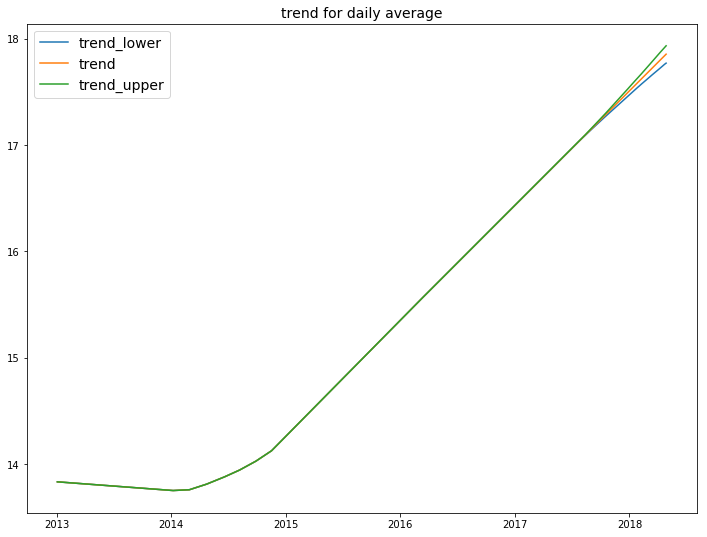

In [40]:
plt.figure(figsize=(12, 9))
for t in ['trend_lower', 'trend', 'trend_upper']:
    plt.plot(T_forecast.ds, getattr(T_forecast, t), label=t)
plt.legend(fontsize=14)
plt.title("trend for daily average", fontsize=14)